In [231]:
%matplotlib inline

In [245]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from pyamg.gallery import poisson, diffusion_stencil_2d, stencil_grid
save = 1

In [246]:
grid = (10,10)
A = poisson(grid).tocsr()
#sten = diffusion_stencil_2d(epsilon=0.001, theta=3.0*np.pi/4, type='FE')
#A = stencil_grid(sten, grid).tocsr()

x_true = np.ones(A.shape[0],)
b = A.dot(x_true)
x = np.random.rand(A.shape[0],)

n_procs = 100
rows_per_proc = (int)(A.shape[0] / n_procs)

In [247]:
def hybrid_jacobi_gs(A, x, b):
    x_old = np.copy(x)
    
    for proc in range(n_procs):
        start = proc * rows_per_proc
        end = (proc+1) * rows_per_proc
        for row in range(start, end):
            diag = 0
            j_sum = 0
            gs_sum = 0
            for j in range(A.indptr[row], A.indptr[row+1]):
                col = A.indices[j]
                val = A.data[j]
                if (col == row):
                    diag = val
                elif (col >= start and col < end):
                    gs_sum += val*x[col]
                else:
                    j_sum += val*x_old[col]
            x[row] = (b[row] - j_sum - gs_sum) / diag

In [248]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation

def update_plot(frame_num, surf, x_true, b, x):
    if frame_num > 0:
        hybrid_jacobi_gs(A, x, b)
        
    error = np.abs(x_true - x)
    E = np.reshape(error, grid)
        
    surf[0].remove()
    surf[0] = ax.plot_surface(X, Y, E, cmap=cm.coolwarm)
    ax.set_zlim(0, 0.8)
    
    return surf

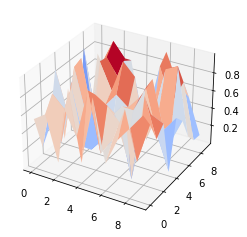

In [249]:
from IPython.display import HTML
fig = plt.figure()
ax = plt.axes(projection='3d')
    
X = np.arange(0, grid[0])
Y = np.arange(0, grid[1])
X, Y = np.meshgrid(X, Y)

error = np.abs(x_true - x)
E = np.reshape(error, grid) 
surf = [ax.plot_surface(X, Y, E, cmap=cm.coolwarm)]
anim = FuncAnimation(fig, update_plot, 15, fargs=(surf, x_true, b, x), interval=1000)

In [250]:
if save:
    anim.save('hybrid100.mp4', writer='ffmpeg', fps=1, dpi=100)

In [251]:
HTML(anim.to_html5_video())